<a href="https://colab.research.google.com/github/biblecompanion/resources/blob/master/BERT_Bible_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Ref](https://rolisz.com/analyzing-the-bible-with-bert-models/)

In [ ]:
!pip install transformers umap-learn plotly pyyaml==5.4.1

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 19.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=48ec8200b52618207b956e753f6db08e47a7a969d3f6801ec0360a78d50b0f1c
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=3a61b5556e3861180d1072688735fe89b37e3a802ffd65b9af5f2e86462548d1
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
from transformers import AutoTokenizer, AutoModel

import re
import numpy as np
import torch
import pandas as pd
import umap
import plotly.express as px

import textwrap

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
!wget https://biblehub.info/data/akjv.txt

--2022-02-13 20:55:27--  https://biblehub.info/data/akjv.txt
Resolving biblehub.info (biblehub.info)... failed: No address associated with hostname.
wget: unable to resolve host address ‘biblehub.info’


In [ ]:
verses = {}
count = 0
with open('akjv.txt', 'r', encoding='utf8') as f:
    lines = f.readlines()
    for line in lines[23146:]:
        try:
            citation, raw_sentence = line.strip().split('\t')
            verses[citation] = raw_sentence
        except ValueError:
            count +=1
print(count)

0


In [ ]:
!wget https://raw.githubusercontent.com/STEPBible/STEPBible-Data/master/TTESV%20-%20Tyndale%20Translation%20tags%20for%20ESV%20-%20TyndaleHouse.com%20STEPBible.org%20CC%20BY-NC.txt -O tags.txt
! tail -n +23356 tags.txt > esv_tags.txt #| sed 's/$Mat/Matthew/;s/$Mrk/Mark/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g; s/$Luk/Luke/g'

--2022-02-13 20:55:30--  https://raw.githubusercontent.com/STEPBible/STEPBible-Data/master/TTESV%20-%20Tyndale%20Translation%20tags%20for%20ESV%20-%20TyndaleHouse.com%20STEPBible.org%20CC%20BY-NC.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4465891 (4.3M) [text/plain]
Saving to: ‘tags.txt’

tags.txt            100%[===================>]   4.26M  --.-KB/s    in 0.07s   

2022-02-13 20:55:30 (64.3 MB/s) - ‘tags.txt’ saved [4465891/4465891]



In [ ]:
strongs_tags = {}
with open("esv_tags.txt", encoding='utf8') as f:
    lines = f.readlines()
    for key, line in zip(verses, lines):
        verse, strongs = line.split("\t", maxsplit=1)
        strongs_tags[key] = strongs

In [ ]:
verses

{'Matthew 1:1': 'The book of the generation of Jesus Christ, the son of David, the son of Abraham.',
 'Matthew 1:2': 'Abraham begat Isaac; and Isaac begat Jacob; and Jacob begat Judas and his brothers;',
 'Matthew 1:3': 'And Judas begat Phares and Zara of Thamar; and Phares begat Esrom; and Esrom begat Aram;',
 'Matthew 1:4': 'And Aram begat Aminadab; and Aminadab begat Naasson; and Naasson begat Salmon;',
 'Matthew 1:5': 'And Salmon begat Booz of Rachab; and Booz begat Obed of Ruth; and Obed begat Jesse;',
 'Matthew 1:6': 'And Jesse begat David the king; and David the king begat Solomon of her that had been the wife of Urias;',
 'Matthew 1:7': 'And Solomon begat Roboam; and Roboam begat Abia; and Abia begat Asa;',
 'Matthew 1:8': 'And Asa begat Josaphat; and Josaphat begat Joram; and Joram begat Ozias;',
 'Matthew 1:9': 'And Ozias begat Joatham; and Joatham begat Achaz; and Achaz begat Ezekias;',
 'Matthew 1:10': 'And Ezekias begat Manasses; and Manasses begat Amon; and Amon begat Jos

In [ ]:
strongs_tags

{'Matthew 1:1': '02=<0976>\t05=<1078>\t07=<2424>\t08=<5547>\t10=<5207>\t12=<1138>\t14=<5207>\t16=<0011>\t\n',
 'Matthew 1:2': '01=<0011>\t04=<1080>\t06=<2464>\t07=<1161>\t08=<2464>\t10=<1080>\t12=<2384>\t13=<1161>\t14=<2384>\t16=<1080>\t18=<2455>\t19=<2532>\t20=<0846>\t21=<0080>\t\n',
 'Matthew 1:3': '01=<1161>\t02=<2455>\t04=<1080>\t06=<5329>\t07=<2532>\t08=<2196>\t09=<1537>\t10=<2283>\t11=<1161>\t12=<5329>\t14=<1080>\t16=<2074>\t17=<1161>\t18=<2074>\t20=<1080>\t22=<0689>\t\n',
 'Matthew 1:4': '01=<1161>\t02=<0689>\t04=<1080>\t06=<0284>\t07=<1161>\t08=<0284>\t10=<1080>\t12=<3476>\t13=<1161>\t14=<3476>\t16=<1080>\t18=<4533>\t\n',
 'Matthew 1:5': '01=<1161>\t02=<4533>\t04=<1080>\t06=<1003>\t07=<1537>\t08=<4477>\t09=<1161>\t10=<1003>\t12=<1080>\t14=<5601>\t15=<1537>\t16=<4503>\t17=<1161>\t18=<5601>\t20=<1080>\t22=<2421>\t\n',
 'Matthew 1:6': '01=<1161>\t02=<2421>\t04=<1080>\t06=<1138>\t08=<0935>\t09=<1161>\t10=<1138>\t13=<1080>\t15=<4672>\t16=<1537>\t18=<3588>\t20=<3774>\t\n',
 'Matthew 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = model = AutoModel.from_pretrained('bert-base-cased', output_hidden_states=True).eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_word_idx(sent: str,  word: str):
    l = re.split('([ .,!?:;""()\'-])', sent)
    l = [x for x in l if x != " " and x != ""]
    return l.index(word)

  
def get_embedding(tokenizer, model, sent, word, layers=None):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
        that make up the word of interest, and then `get_hidden_states`."""
    layers = [-4, -3, -2, -1] if layers is None else layers

    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    
    idx = get_word_idx(sent, word)
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
 
    with torch.no_grad():
        output = model(**encoded)
 
    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]
 
    return word_tokens_output.mean(dim=0)
 
 

In [ ]:
encoded= tokenizer.encode_plus("I love pizza", return_tensors="pt")
encoded.tokens(), encoded.word_ids()

(['[CLS]', 'I', 'love', 'pizza', '[SEP]'], [None, 0, 1, 2, None])

In [ ]:
encoded = tokenizer.encode_plus("I love aardvarks", return_tensors="pt")
encoded.tokens(), encoded.word_ids()

(['[CLS]', 'I', 'love', 'a', '##ard', '##var', '##ks', '[SEP]'],
 [None, 0, 1, 2, 2, 2, 2, None])

In [ ]:
books = []
for k in verses:
    book = k[:k.index(" ", 4)]
    if book not in books:
        books.append(book)
print(books)

['Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians', 'Galatians', 'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude', 'Revelation']


In [ ]:
def get_all_embeddings(greek_words, english_words):
    embeddings = []

    for key, t in verses.items():
        strongs = strongs_tags[key]
        for word in greek_words:
            for number in greek_words[word]:
                if number in strongs:
                    gw = word

                    for v in english_words:
                        try:
                            if v in t:
                                emb = get_embedding(tokenizer, model, t, v).numpy()
                                book = books.index(key[:key.index(" ", 4)])
                                embeddings.append((emb, f"{key} {t}",  gw, book))
                                break
                        except ValueError as e:
                            print("Embedding not found", t)
                    else:
                        print("English word not found", key, t)
    return embeddings

In [ ]:
strongs_numbers = {
    "agape": ["0025", "0026"],
    "phileo": ["5368", "5360", "5363", "5362", "5361", "5366", "5365", "5377"],
}
word_list = ["lovers", "loved", "loves", "love", "Love"]

embeddings = get_all_embeddings(strongs_numbers, word_list)

English word not found Matthew 26:48 Now he that betrayed him gave them a sign, saying, Whomsoever I shall kiss, that same is he: hold him fast.
English word not found Mark 14:44 And he that betrayed him had given them a token, saying, Whomsoever I shall kiss, that same is he; take him, and lead him away safely.
English word not found Luke 16:14 And the Pharisees also, who were covetous, heard all these things: and they derided him.
English word not found Luke 22:47 And while he yet spoke, behold a multitude, and he that was called Judas, one of the twelve, went before them, and drew near to Jesus to kiss him.
English word not found Acts 28:2 And the barbarous people showed us no little kindness: for they kindled a fire, and received us every one, because of the present rain, and because of the cold.
Embedding not found As he said also in Osee, I will call them my people, which were not my people; and her beloved, which was not beloved.
Embedding not found As he said also in Osee, I wi

In [ ]:
def get_book_type(idx):
    if idx < 4:
        return 'Gospels'
    if idx < 19:
        return 'Pauline letters'
    if idx < 26:
        return 'Short lettters'
    return 'Revelation'

In [ ]:
mapper = umap.UMAP().fit([x[0] for x in embeddings])
ts = mapper.embedding_

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
x = ts[:,0]
y = ts[:,1]
df = pd.DataFrame({"x": x, "y": y, "verse": ["<br>".join(textwrap.wrap(x[1], 80)) for x in embeddings], "books": [get_book_type(x[3]) for x in embeddings]})
fig = px.scatter(df, x="x", y="y",
                 hover_data=['verse'], color="books", )
fig.write_html("book_love.html")
fig.show()

In [ ]:
x = ts[:,0]
y = ts[:,1]
df = pd.DataFrame({"x": x, "y": y, "verse": ["<br>".join(textwrap.wrap(x[1], 80)) for x in embeddings], "greek word": [x[2] for x in embeddings]})
fig = px.scatter(df, x="x", y="y",
                 hover_data=['verse'], color="greek word", )
fig.write_html("greek_love.html")
fig.show()

In [ ]:
# Spirit vs soul

In [ ]:
strongs_numbers = {
    "pneuma": ["4151"],
    "psuche": ["5590"],
}
word_list = ["spirits", "souls", "Spirits", "soul", "spirit","Spirit"]

embeddings = get_all_embeddings(strongs_numbers, word_list)



English word not found Matthew 1:18 Now the birth of Jesus Christ was on this wise: When as his mother Mary was espoused to Joseph, before they came together, she was found with child of the Holy Ghost.
English word not found Matthew 1:20 But while he thought on these things, behold, the angel of the LORD appeared to him in a dream, saying, Joseph, you son of David, fear not to take to you Mary your wife: for that which is conceived in her is of the Holy Ghost.
English word not found Matthew 2:20 Saying, Arise, and take the young child and his mother, and go into the land of Israel: for they are dead which sought the young child's life.
English word not found Matthew 3:11 I indeed baptize you with water to repentance. but he that comes after me is mightier than I, whose shoes I am not worthy to bear. he shall baptize you with the Holy Ghost, and with fire.
English word not found Matthew 6:25 Therefore I say to you, Take no thought for your life, what you shall eat, or what you shall dr

In [ ]:
mapper = umap.UMAP().fit([x[0] for x in embeddings])


In [ ]:
ts = mapper.embedding_
x = ts[:,0]
y = ts[:,1]
df = pd.DataFrame({"x": x, "y": y, "verse": ["<br>".join(textwrap.wrap(x[1], 80)) for x in embeddings], "greek word": [x[2] for x in embeddings]})
fig = px.scatter(df, x="x", y="y",
                 hover_data=['verse'], color="greek word", )
fig.write_html("greek_ss.html")
fig.show()

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-cased')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
verses = {}
count = 0
with open('akjv.txt', 'r', encoding='utf8') as f:
    lines = f.readlines()
    for line in lines[23146:]:
        try:
            citation, raw_sentence = line.strip().split('\t')
            verses[citation] = raw_sentence
        except ValueError:
            count +=1

In [ ]:

def mask_and_predict(word_list):
    predictions = []
    for key, t in verses.items():
        for v in word_list:
                if v in t:
                    try:
                        new_t = re.sub(f"\\b{v}\\b", "[MASK]", t)
                        top_preds = unmasker(new_t)
                        if type(top_preds[0]) == list:
                            top_preds = top_preds[0]
                        predictions.append((f"{key} {t}",  v, top_preds))
                        break
                    except Exception:
                        print(new_t, v)
    return predictions


embeddings = mask_and_predict(["spirits", "Spirits", "souls", "soul's", "spirit", "Spirit", "soul",])

For I long to see you, that I may impart to you some spiritual gift, to the end you may be established; spirit
For we know that the law is spiritual: but I am carnal, sold under sin. spirit
For to be carnally minded is death; but to be spiritually minded is life and peace. spirit
It has pleased them truly; and their debtors they are. For if the Gentiles have been made partakers of their spiritual things, their duty is also to minister to them in carnal things. spirit
Which things also we speak, not in the words which man's wisdom teaches, but which the Holy Ghost teaches; comparing spiritual things with spiritual. spirit
But the natural man receives not the things of the Spirit of God: for they are foolishness to him: neither can he know them, because they are spiritually discerned. spirit
But he that is spiritual judges all things, yet he himself is judged of no man. spirit
And I, brothers, could not speak to you as to spiritual, but as to carnal, even as to babes in Christ. spirit
If

In [ ]:
y_true = []
y_pred = []
for v, gw, pred in embeddings:
    if 'pirit' in gw:
        y_true.append('spirit')
    elif 'soul' in gw:
        y_true.append('soul')
    for pr in pred:
        pr = pr['token_str']
        if 'pirit' in pr:
            y_pred.append('spirit')
            break
        elif 'soul' in pr:
            y_pred.append('soul')
            break
    else:
        y_pred.append("else")

            

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

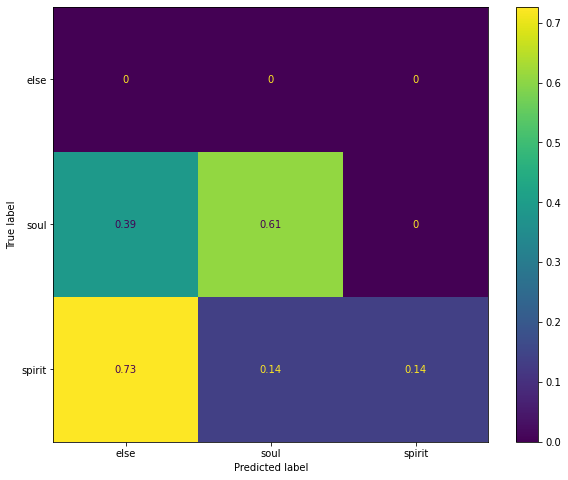

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true') # berean